In [7]:
# === IMPORTS ===
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import shared preprocessing functions
from add_preprocessing import load_and_prepare_data, create_preprocessor

# === LOAD & PREPARE DATA ===
X, y = load_and_prepare_data("../Motor_vehicle_insurance_data.csv")
preprocessor = create_preprocessor(X)

# === MODEL PIPELINE WITH LINEAR REGRESSION ===
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# === TRAIN-TEST SPLIT & MODEL TRAINING ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# === PREDICT AND CONVERT TO CLASSES ===
y_pred_continuous = model.predict(X_test)
y_pred_binary = (y_pred_continuous >= 0.5).astype(int)

# === EXPORT MODEL TO MODELS FOLDER ===
joblib.dump(model, "../models/linear_regression_model.pkl")
print("✅ Linear Regression model saved as '../models/linear_regression_model.pkl'")

/Users/alper/Desktop/cse2600/model_codes/add_preprocessing.py:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, delimiter=delimiter)


✅ Linear Regression model saved as '../models/linear_regression_model.pkl'


/Users/alper/Desktop/cse2600/model_codes/add_preprocessing.py:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, delimiter=delimiter)


✅ Linear Regression Model Evaluation
------------------------------
Accuracy: 0.7938515465870873
ROC AUC Score: 0.7090985430563304

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.05      0.09      4361
           1       0.80      0.99      0.88     16750

    accuracy                           0.79     21111
   macro avg       0.66      0.52      0.49     21111
weighted avg       0.74      0.79      0.72     21111



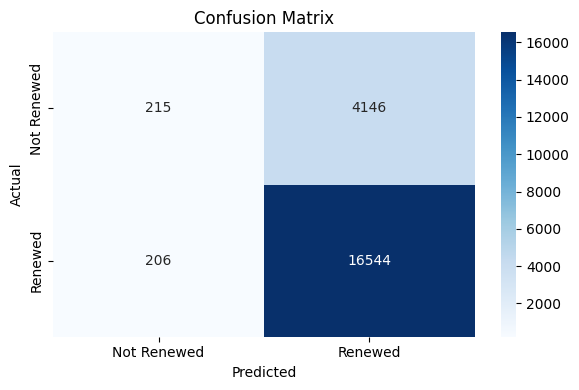

In [8]:
# === IMPORTS ===
import joblib
import pandas as pd
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === LOAD RAW TEST DATA ===
# IMPORTANT: we must load raw features, not already preprocessed data
from add_preprocessing import load_and_prepare_data

# Load full dataset (same as training)
X_full, y_full = load_and_prepare_data("../Motor_vehicle_insurance_data.csv")

# Train-test split again with SAME random_state
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# === LOAD SAVED LINEAR REGRESSION MODEL ===
model = joblib.load("../models/linear_regression_model.pkl")

# === PREDICT ON RAW TEST SET ===
y_pred_scores = model.predict(X_test_raw)               # Continuous scores
y_pred = (y_pred_scores >= 0.5).astype(int)              # Convert to 0 or 1
y_prob = y_pred_scores                                  # Use scores for ROC AUC

# === EVALUATE MODEL PERFORMANCE ===
print("✅ Linear Regression Model Evaluation")
print("-" * 30)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === DISPLAY CONFUSION MATRIX ===
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Not Renewed', 'Renewed'],
            yticklabels=['Not Renewed', 'Renewed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()